In [1]:
import math
import string
import re
from collections import defaultdict
import random
import gc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models
import pyLDAvis.gensim

import os
import tempfile
import logging

TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

c:\users\gyorgym\apps\miniconda3\envs\dl\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Folder "C:\Users\GyorgyM\AppData\Local\Temp" will be used to save temporary dictionary and corpus.


In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
tweets_csv = pd.read_csv("Data/twcs.csv")

# nltk.download("stopwords")
# nltk.download("wordnet")

tweets_csv.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [4]:
tweets = tweets_csv.copy()

first_mask = tweets.in_response_to_tweet_id.isnull()
first_tweet_ids = tweets.loc[first_mask, "tweet_id"].values
tweet_conversation = pd.DataFrame({"tweet_id": first_tweet_ids, 
                                   "conversation_id": np.arange(first_tweet_ids.size) + 1}, 
                                  dtype="int64")

unmatched_tweets = tweets.loc[~first_mask, ["tweet_id", "in_response_to_tweet_id"]].astype("int64")

results = tweet_conversation.copy()

i = 1
while not tweet_conversation.empty:
    merged = pd.merge(unmatched_tweets, tweet_conversation, how="left", left_on="in_response_to_tweet_id", right_on="tweet_id", 
                      suffixes=("", "_parent"))
    matched_mask = merged.tweet_id_parent.notnull()
    tweet_conversation = merged.loc[matched_mask, tweet_conversation.columns]
    results = results.append(tweet_conversation.copy(), ignore_index=True)
    unmatched_tweets = merged.loc[~matched_mask, unmatched_tweets.columns]
    
#     i = i + 1
#     if i > 1:
#         break


results["conversation_id"] = results.conversation_id.astype("int64")

tweets = pd.merge(tweets, results, on="tweet_id")

channels = tweets[~tweets.author_id.str.match(r"[0-9]+$")].groupby("conversation_id")["author_id"].first().to_frame("channel")
tweets = pd.merge(tweets, channels, left_on="conversation_id", right_index=True)

tweets.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,conversation_id,channel
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,1,sprintcare
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,1,sprintcare
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,1,sprintcare
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,1,sprintcare
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,1,sprintcare


In [5]:
tweets.groupby("channel").count().sort_values("conversation_id", ascending=False)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,conversation_id
channel,,,,,,,,
AmazonHelp,370222,370222,370222,370222,370222,251311,288378,370222
AppleSupport,237443,237443,237443,237443,237443,149034,157129,237443
Uber_Support,127801,127801,127801,127801,127801,78613,86038,127801
SpotifyCares,91459,91459,91459,91459,91459,58757,63278,91459
Delta,86553,86553,86553,86553,86553,50899,60595,86553
AmericanAir,85822,85822,85822,85822,85822,54815,59757,85822
TMobileHelp,79242,79242,79242,79242,79242,49899,56762,79242
Tesco,71824,71824,71824,71824,71824,39682,55236,71824
comcastcares,71468,71468,71468,71468,71468,42432,47660,71468


In [55]:
conversations = tweets.groupby("conversation_id")["text"].apply(lambda s: s.str.cat(sep=" "))
conversations.head()

conversation_id
1    @115712 I understand. I would like to assist y...
2    @115713 This is saddening to hear. Please shoo...
3    @115715 Please send me a private message so th...
4    @115716 What information is incorrect? ^JK @As...
5    @115717 Hello, My apologies for any frustratio...
Name: text, dtype: object

In [56]:
tokenizer = RegexpTokenizer(r"[\w-]+")
stop = set(stopwords.words('english'))
num_pattern = re.compile(r"[0-9-]+$")
url_pattern = re.compile(r"https\:\/\/t\.co\/[a-zA-Z0-9]+")

def get_cleaned_doc(doc):
    url_removed = url_pattern.sub("?", doc)
    lower = url_removed.lower()
    tokenized = tokenizer.tokenize(lower)
    stop_removed = [word for word in tokenized if word not in stop]
    num_removed = [word for word in stop_removed if num_pattern.match(word) is None]
    return num_removed

all_docs = [get_cleaned_doc(doc) for doc in conversations]

global_dictionary = corpora.Dictionary(all_docs)
global_doc_term_matrix = [dictionary.doc2bow(doc) for doc in all_docs]

global_tfidf = models.TfidfModel(global_doc_term_matrix, dictionary=global_dictionary)

In [6]:
channel_tweets = tweets[tweets.channel == "Uber_Support"]
channel_conversations = channel_tweets.groupby("conversation_id")["text"].apply(lambda s: s.str.cat(sep=" "))
channel_conversations.head()

conversation_id
113    @115872 Happy to follow up! Contact us via htt...
114    @115874 We're here to help! Send us a note her...
115    @115875 We’re here to help, Travis! Send us a ...
116    @115876 For more info about UberEats availabil...
117    @115878 We have received your DM and will foll...
Name: text, dtype: object

In [7]:
channel_conversations.to_csv("Data/channel_conversations.csv")

In [23]:
tokenizer = RegexpTokenizer(r"[\w-]+")
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
num_pattern = re.compile(r"[0-9-]+$")
url_pattern = re.compile(r"https\:\/\/t\.co\/[a-zA-Z0-9]+")
# sign_pattern = re.compile(r"[\^-]")

def get_cleaned_doc(doc):
    url_removed = url_pattern.sub("?", doc)
    lower = url_removed.lower()
    tokenized = tokenizer.tokenize(lower)
    stop_removed = [word for word in tokenized if word not in stop]
    num_removed = [word for word in stop_removed if num_pattern.match(word) is None]
    lemmatized = [lemmatizer.lemmatize(word) for word in num_removed]
    return lemmatized

docs = [get_cleaned_doc(doc) for doc in channel_conversations]

In [8]:
rand_ind = np.random.randint(len(docs))
print(rand_ind)
print(channel_conversations.iloc[rand_ind])
print(docs[rand_ind])

21084
@478186 Here to help! Send us a note via https://t.co/DpLEahcQAT so our team can connect. @115877 waited an hour for Umami, receipt is correct, order completely wrong. We need this fixed ASAP and there’s no number to call!
['help', 'send', 'us', 'note', 'via', 'team', 'connect', 'waited', 'hour', 'umami', 'receipt', 'correct', 'order', 'completely', 'wrong', 'need', 'fixed', 'asap', 'number', 'call']


In [38]:
token_freq = defaultdict(int)
for doc in docs:
    for token in doc:
        token_freq[token] += 1

print("number of unique tokens: " + str(len(token_freq)))
print("tokens used only once: " + str(sum(freq == 1 for freq in token_freq.values())))

number of unique tokens: 29256
tokens used only once: 16281


In [32]:
len(word_freq.keys())

31082

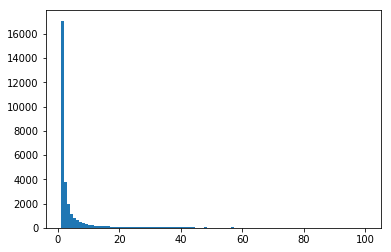

In [10]:
plt.hist(token_freq.values(), bins=100, range=(1, 100));

In [30]:
logging.getLogger().setLevel(logging.CRITICAL)
dictionary = corpora.Dictionary(docs)
print("dictionary size: " + str(len(dictionary.keys())))
dictionary.filter_extremes(no_below=40, no_above=0.5)
print("dictionary size after filtering extremes: " + str(len(dictionary.keys())))
doc_term_matrix = [dictionary.doc2bow(doc) for doc in docs]

dictionary size: 29256
dictionary size after filtering extremes: 1814


In [29]:
len(dictionary.keys())

1814

In [20]:
logging.getLogger().setLevel(logging.DEBUG)

lda = models.LdaModel(doc_term_matrix, id2word=dictionary, num_topics=20, alpha='auto', eta=0.01, iterations=200, passes=1)


2018-08-10 10:20:06,015 : INFO : using autotuned alpha, starting with [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
2018-08-10 10:20:06,017 : INFO : using serial LDA version on this node
2018-08-10 10:20:06,106 : INFO : running online (single-pass) LDA training, 20 topics, 1 passes over the supplied corpus of 41763 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 200x with a convergence threshold of 0.001000
2018-08-10 10:20:06,108 : INFO : PROGRESS: pass 0, at document #2000/41763
2018-08-10 10:20:06,108 : DEBUG : performing inference on a chunk of 2000 documents
2018-08-10 10:20:08,164 : DEBUG : 1849/2000 documents converged within 200 iterations
2018-08-10 10:20:08,180 : INFO : optimized alpha [0.047931682, 0.04110542, 0.042236436, 0.041517995, 0.04061349, 0.04799138, 0.04238947, 0.040669207, 0.04456491, 0.041888773, 0.043511905, 0.04205518, 0.0423672

2018-08-10 10:20:13,854 : INFO : optimized alpha [0.051575467, 0.04951269, 0.039767336, 0.043499436, 0.038111556, 0.04735844, 0.041766386, 0.040991805, 0.04376487, 0.040236976, 0.04109275, 0.039827034, 0.0396445, 0.04324778, 0.04524483, 0.04288601, 0.04271513, 0.04357026, 0.04734885, 0.04118188]
2018-08-10 10:20:13,870 : DEBUG : updating topics
2018-08-10 10:20:13,901 : INFO : merging changes from 2000 documents into a model of 41763 documents
2018-08-10 10:20:14,019 : INFO : topic #4 (0.038): 0.037*"us" + 0.034*"uber" + 0.033*"uber_support" + 0.031*"dm" + 0.024*"send" + 0.024*"email" + 0.022*"driver" + 0.021*"ride" + 0.020*"please" + 0.018*"address"
2018-08-10 10:20:14,035 : INFO : topic #12 (0.040): 0.037*"uber_support" + 0.023*"us" + 0.022*"send" + 0.019*"help" + 0.016*"team" + 0.016*"please" + 0.014*"email" + 0.014*"dm" + 0.013*"follow" + 0.012*"uber"
2018-08-10 10:20:14,035 : INFO : topic #5 (0.047): 0.055*"uber_support" + 0.035*"help" + 0.032*"us" + 0.029*"email" + 0.028*"dm" + 0

2018-08-10 10:20:18,583 : INFO : topic #0 (0.054): 0.043*"uber_support" + 0.030*"us" + 0.029*"driver" + 0.021*"please" + 0.019*"send" + 0.018*"uber" + 0.017*"email" + 0.016*"dm" + 0.015*"help" + 0.013*"address"
2018-08-10 10:20:18,583 : INFO : topic #1 (0.061): 0.090*"note" + 0.088*"send" + 0.079*"us" + 0.076*"help" + 0.067*"team" + 0.043*"connect" + 0.021*"uber" + 0.019*"via" + 0.018*"get" + 0.018*"ride"
2018-08-10 10:20:18,583 : INFO : topic diff=inf, rho=0.333333
2018-08-10 10:20:18,647 : DEBUG : bound: at document #0
2018-08-10 10:20:19,823 : INFO : -11.700 per-word bound, 3325.9 perplexity estimate based on a held-out corpus of 2000 documents with 53814 words
2018-08-10 10:20:19,838 : INFO : PROGRESS: pass 0, at document #20000/41763
2018-08-10 10:20:19,838 : DEBUG : performing inference on a chunk of 2000 documents
2018-08-10 10:20:20,827 : DEBUG : 1999/2000 documents converged within 200 iterations
2018-08-10 10:20:20,843 : INFO : optimized alpha [0.054990366, 0.0644674, 0.04027

2018-08-10 10:20:25,369 : DEBUG : updating topics
2018-08-10 10:20:25,412 : INFO : merging changes from 2000 documents into a model of 41763 documents
2018-08-10 10:20:25,533 : INFO : topic #4 (0.040): 0.032*"uber_support" + 0.031*"us" + 0.030*"uber" + 0.022*"charged" + 0.022*"dm" + 0.020*"email" + 0.020*"offer" + 0.019*"assist" + 0.019*"trip" + 0.019*"driver"
2018-08-10 10:20:25,535 : INFO : topic #12 (0.042): 0.032*"uber_support" + 0.016*"drivers" + 0.016*"us" + 0.014*"follow" + 0.012*"please" + 0.012*"ok" + 0.012*"show" + 0.011*"uber" + 0.011*"every" + 0.010*"send"
2018-08-10 10:20:25,537 : INFO : topic #13 (0.057): 0.166*"sorry" + 0.130*"hear" + 0.067*"us" + 0.063*"trouble" + 0.043*"experience" + 0.035*"via" + 0.035*"contact" + 0.033*"please" + 0.028*"touch" + 0.028*"driver"
2018-08-10 10:20:25,539 : INFO : topic #0 (0.059): 0.042*"uber_support" + 0.031*"driver" + 0.027*"us" + 0.018*"please" + 0.017*"uber" + 0.016*"send" + 0.012*"email" + 0.011*"help" + 0.011*"dm" + 0.010*"address"

2018-08-10 10:20:29,761 : INFO : topic #1 (0.089): 0.106*"note" + 0.101*"send" + 0.089*"us" + 0.083*"help" + 0.077*"team" + 0.047*"connect" + 0.026*"via" + 0.021*"uber_support" + 0.019*"assist" + 0.017*"get"
2018-08-10 10:20:29,761 : INFO : topic diff=inf, rho=0.235702
2018-08-10 10:20:29,776 : INFO : PROGRESS: pass 0, at document #38000/41763
2018-08-10 10:20:29,776 : DEBUG : performing inference on a chunk of 2000 documents
2018-08-10 10:20:30,530 : DEBUG : 1999/2000 documents converged within 200 iterations
2018-08-10 10:20:30,561 : INFO : optimized alpha [0.06713639, 0.09473464, 0.044358604, 0.055827357, 0.041615598, 0.06020395, 0.05819118, 0.058894586, 0.04866975, 0.05013008, 0.047053013, 0.045185078, 0.045564104, 0.0640794, 0.051285777, 0.049042277, 0.049814615, 0.05352829, 0.060657002, 0.04952877]
2018-08-10 10:20:30,564 : DEBUG : updating topics
2018-08-10 10:20:30,611 : INFO : merging changes from 2000 documents into a model of 41763 documents
2018-08-10 10:20:30,712 : INFO : 

In [21]:
lda.show_topics()

[(4,
  '0.031*"uber_support" + 0.026*"uber" + 0.024*"assist" + 0.024*"us" + 0.022*"offer" + 0.022*"support" + 0.021*"phone" + 0.019*"charged" + 0.018*"twice" + 0.018*"inconvenience"'),
 (2,
  '0.048*"please" + 0.035*"us" + 0.035*"account" + 0.031*"contact" + 0.030*"uber_support" + 0.028*"due" + 0.027*"policy" + 0.025*"holder" + 0.022*"speak" + 0.021*"know"'),
 (11,
  '0.067*"uber_support" + 0.053*"via" + 0.048*"dm" + 0.027*"followed" + 0.024*"please" + 0.020*"check" + 0.016*"support" + 0.013*"response" + 0.011*"hours" + 0.010*"sent"'),
 (12,
  '0.023*"uber_support" + 0.020*"drivers" + 0.019*"demand" + 0.013*"every" + 0.011*"everyone" + 0.011*"show" + 0.011*"ok" + 0.010*"time" + 0.010*"us" + 0.010*"joke"'),
 (10,
  '0.044*"uber_support" + 0.038*"soon" + 0.029*"ride" + 0.026*"appreciate" + 0.025*"patience" + 0.024*"possible" + 0.022*"pass" + 0.020*"email" + 0.018*"team" + 0.015*"promotions"'),
 (5,
  '0.049*"help" + 0.049*"email" + 0.047*"address" + 0.046*"uber_support" + 0.046*"dm" + 0.

In [17]:
lda.top_topics(corpus=doc_term_matrix, texts=docs, coherence="c_v")

2018-08-10 10:16:51,248 : DEBUG : Setting topics to those of the model: LdaModel(num_terms=31082, num_topics=100, decay=0.5, chunksize=2000)
2018-08-10 10:16:51,260 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2018-08-10 10:17:19,754 : INFO : 500 batches submitted to accumulate stats from 32000 documents (-2576052 virtual)
2018-08-10 10:17:30,314 : INFO : 7 accumulators retrieved from output queue
2018-08-10 10:17:35,091 : INFO : accumulated word occurrence stats for 86711 virtual documents


[([(0.0837672, 'soon'),
   (0.06875159, 'team'),
   (0.06418189, 'uber_support'),
   (0.05936106, 'member'),
   (0.058324527, 'possible'),
   (0.044058774, 'following'),
   (0.039445374, 'patience'),
   (0.036438253, 'see'),
   (0.03044681, 'appreciate'),
   (0.025780328, 'outreach'),
   (0.024546945, 'via'),
   (0.017735468, 'email'),
   (0.01565028, 'thank'),
   (0.0144070955, 'keep'),
   (0.014185774, 'follow'),
   (0.013671677, 'support'),
   (0.012352693, 'received'),
   (0.011856858, 'respond'),
   (0.011585093, 'back'),
   (0.010826036, 'hi')],
  0.7032270436351205),
 ([(0.09096722, 'uber_support'),
   (0.055960335, 'support'),
   (0.052961923, 'please'),
   (0.042498495, 'team'),
   (0.040326994, 'via'),
   (0.034731466, 'check'),
   (0.030500945, 'reply'),
   (0.029221749, 'email'),
   (0.028754836, 'in-app'),
   (0.026672672, 'dm'),
   (0.026583677, 'member'),
   (0.025761496, 'response'),
   (0.019609053, 'reached'),
   (0.01850132, 'messages'),
   (0.01833737, 'followed'),


In [22]:
prepared = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary, mds="tsne")
pyLDAvis.display(prepared)

2018-08-10 10:20:45,272 : DEBUG : performing inference on a chunk of 41763 documents
2018-08-10 10:20:58,951 : DEBUG : 41757/41763 documents converged within 200 iterations


In [29]:
def eval_config(corpus, texts, n_topics, k=10, iterations=100, passes=1, multicore=False):
    def get_lda_model(train_corpus):
        if multicore:
            return models.LdaMulticore(train_corpus, id2word=dictionary, num_topics=n_topics, alpha='asymmetric', eta='auto', 
                                       iterations=iterations, passes=passes)
        return models.LdaModel(train_corpus, id2word=dictionary, num_topics=n_topics, alpha='auto', eta='auto', 
                               iterations=iterations, passes=passes)
    
    random.shuffle(corpus)
    perps = []
    for i in range(k):
        val_from = round(i / k * len(corpus)) if k > 1 else 0
        val_to = round((i + 1) / k * len(corpus)) if k > 1 else 0
        train = corpus[:val_from] + corpus[val_to:]
        val = corpus[val_from:val_to]
        
        lda = get_lda_model(train)
        perps.append(lda.log_perplexity(val if k > 1 else train))
        print("fold " + str(i + 1) + "/" + str(k) + " finished")
    
    lda = get_lda_model(corpus)
    umass = models.CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
    cv = models.CoherenceModel(model=lda, texts=texts, coherence='c_v')
    
    return (perps, umass.get_coherence(), cv.get_coherence())

In [ ]:
logging.getLogger().setLevel(logging.CRITICAL)
topics = [2, 5, 10, 20, 40]
results = [eval_config(doc_term_matrix, docs, n_topics) for n_topics in topics]


In [44]:
print([np.mean(result[0]) for result in results])
print([np.std(result[0]) for result in results])
print([result[1] for result in results])
print([result[2] for result in results])


[-9.460213088399843, -8.20707341291116, -8.3883343175356, -8.972255930606371, -9.938291598316527]
[5.184066509913219, 0.053568441831673454, 0.0462847499017894, 0.05674754296853849, 0.07526485163454208]
[-1.4325694854271522, -1.8012235981559552, -1.973273270361655, -2.540583341119082, -3.0509011540920974]
[0.4822668895043883, 0.42301860259232543, 0.473822845014266, 0.4244568741772167, 0.3980611639436921]


In [45]:
res2 = eval_config(doc_term_matrix, docs, 20, iterations=400)
print(res2)

fold 1/10 finished
fold 2/10 finished
fold 3/10 finished
fold 4/10 finished
fold 5/10 finished
fold 6/10 finished
fold 7/10 finished
fold 8/10 finished
fold 9/10 finished
fold 10/10 finished
([-9.006302882648942, -8.935980322627854, -8.986095100136598, -9.010828989622635, -9.01028964540503, -8.930294619761513, -9.014408328851909, -9.01743388400019, -8.949688559564574, -8.998287553734487], -2.499605551544837, 0.44429248544329314)


In [20]:
logging.getLogger().setLevel(logging.WARNING)

random.shuffle(doc_term_matrix)

n_topics = 5
k = 10

def get_lda_model(corpus, multicore=False):
    iterations = 100
    passes = 1
    if multicore:
        return models.LdaMulticore(corpus, id2word=dictionary, num_topics=n_topics, alpha='asymmetrix', eta='auto', 
                                   iterations=iterations, passes=passes)
    return models.LdaModel(corpus, id2word=dictionary, num_topics=n_topics, alpha='auto', eta='auto', 
                           iterations=iterations, passes=passes)

results = []
for i in range(k):
#     print("starting fold " + str(i + 1) "/" + str(k))
    val_from = round(i / k * len(doc_term_matrix)) if k > 1 else 0
    val_to = round((i + 1) / k * len(doc_term_matrix)) if k > 1 else 0
    train = doc_term_matrix[:val_from] + doc_term_matrix[val_to:]
    val = doc_term_matrix[val_from:val_to]
    
    lda = get_lda_model(train)
#     lda = models.LdaMulticore(train, id2word=dictionary, num_topics=n_topics, alpha='asymmetrix', eta='auto', iterations=100, passes=1)
    perp = lda.log_perplexity(val if k > 1 else train)
    print("fold: " + str(i + 1) + ", log perplexity: " + str(perp))
    results.append(perp)

print("mean log perplexity: " + str(np.mean(results)) + ", sd: " + str(np.std(results)))

# logging.getLogger().setLevel(logging.DEBUG)
lda = get_lda_model(doc_term_matrix)

umass = models.CoherenceModel(model=lda, corpus=doc_term_matrix, coherence='u_mass')
cv = models.CoherenceModel(model=lda, texts=docs, coherence='c_v')

print("u_mass: " + str(umass.get_coherence()) + ", c_v: " + str(cv.get_coherence()))

prepared = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary, mds="tsne")


fold: 1, log perplexity: -8.111186238620393
fold: 2, log perplexity: -8.27317993042981
fold: 3, log perplexity: -8.218313814085452
fold: 4, log perplexity: -8.237447595401056
fold: 5, log perplexity: -8.27766853121485
fold: 6, log perplexity: -8.191796364413495
fold: 7, log perplexity: -8.231540953878472
fold: 8, log perplexity: -8.211545111824616
fold: 9, log perplexity: -8.249666952504047
fold: 10, log perplexity: -8.07007105957093
mean log perplexity: -8.207241655194313, sd: 0.06405672986097985
u_mass: -1.7123679483335679, c_v: 0.48787384147285817


In [50]:
tfidf = models.TfidfModel(doc_term_matrix, dictionary=dictionary)
lda = models.LdaModel(tfidf[doc_term_matrix], id2word=dictionary, num_topics=20, alpha='auto', eta='auto', iterations=400, passes=1)
prepared = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary, mds="tsne")
pyLDAvis.display(prepared)

In [51]:
cm = models.CoherenceModel(lda, texts=docs, coherence='c_v')
cm.get_coherence_per_topic()

[0.5548563176031486,
 0.3835553953532903,
 0.41687426870486677,
 0.45373226506471276,
 0.4657053784336787,
 0.429838298077425,
 0.3487481699741054,
 0.30097216892455825,
 0.50068408592765,
 0.39860903575536344,
 0.4276141152640503,
 0.6178967043700831,
 0.3287008670825874,
 0.40486401642522196,
 0.29962333274422065,
 0.3856223189631699,
 0.2795186849823964,
 0.36063462537355395,
 0.33158197410735907,
 0.4465618448287477]

In [54]:
np.std(cm.get_coherence_per_topic())

0.08391087768211222

In [34]:
gc.collect()

511